## Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


from custom_functions import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin



## Load train data

In [2]:
X_train = pd.read_csv(
    "drugsComTrain_raw.tsv",
    sep='\t',
    usecols=[
        "review",
        ],
    )
y_train = pd.read_csv(
    "drugsComTrain_raw.tsv",
    sep='\t',
    usecols=[
        "rating"
        ],
        )

X_test = pd.read_csv(
    "drugsComTest_raw.tsv",
    sep='\t',
    usecols=[
        "review"
        ],
        )
y_test = pd.read_csv(
    "drugsComTest_raw.tsv",
    sep='\t',
    usecols=[
        "rating"
        ],
        )

### Prepare dependent variable for seniment analysis
- Binning rating into bad, mid and good ratings
- bad -> rating 1-4
- mid -> rating 5-7
- good -> rating 8-10


In [3]:
#check binning
print(
    list(
        pd.cut(
            x=np.arange(1,11,1),
            bins=[0,4,7,11],
            labels=['bad','mid','good']
        )
            )
    )

['bad', 'bad', 'bad', 'bad', 'mid', 'mid', 'mid', 'good', 'good', 'good']


In [4]:
_y_train = pd.cut(
    x=y_train['rating'],
    bins=[0,4,7,11],
    labels=['bad','mid','good'],
    )
_y_test = pd.cut(
    x=y_test['rating'],
    bins=[0,4,7,11],
    labels=['bad','mid','good'],
    )

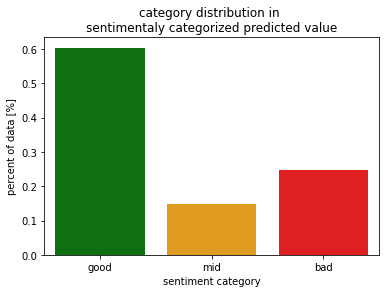

In [5]:
sns.barplot(
    x=_y_train.value_counts(normalize = True).index, 
    y=_y_train.value_counts(normalize = True).values, 
    order=["good", "mid", "bad"],
    palette=["green", "orange", "red"]
    )
plt.title("category distribution in \nsentimentaly categorized predicted value")
plt.ylabel("percent of data [%]")
plt.xlabel("sentiment category")
plt.show()

## Prepare text data for analysis

### method I - vector of words

In [6]:
# vector of words
vectorizer = CountVectorizer(
    max_df=0.90,
    min_df=2,
    max_features=200,
    stop_words='english',
    )
vectorizer.fit(X_train["review"])
vec = vectorizer.transform(X_train["review"])

In [7]:
filename = 'models/countvectorizer.sav'
joblib.dump(vectorizer, filename)

['models/countvectorizer.sav']

### method II - term frequency inverse document frequency

In [8]:
#tfidf method
tfidfvectorizer=TfidfVectorizer(
    max_df=0.90,
    min_df=2,
    max_features=200,
    stop_words='english'
    )
tfidfvectorizer.fit(X_train["review"])
tfidf=tfidfvectorizer.transform(X_train["review"])

In [7]:
filename = 'models/tfidfvectorizer.sav'
joblib.dump(tfidfvectorizer, filename)

## Model selection

In [11]:
# change y for XGBClassifier
_y_train = _y_train.map({"bad":0,"mid":1,"good":2})
_y_test = _y_test.map({"bad":0,"mid":1,"good":2})

In [17]:
names = [
    'LogisticRegression',
    "MultinominalNB",
    "RandomForestClassifier",
    "XGBClassifier",
    ]
models = [
    LogisticRegression(solver="liblinear"), 
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, max_depth=10),  
    XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss'),
    ]
train_data = vec
test_data = vectorizer.transform(X_test["review"])
f1 = []
accuracy = []
precision = []
recall = []


for model_name, model in zip(names, models):
    model.fit(train_data, _y_train)

    y_pred = model.predict(test_data)
    _f1_score = f1_score(_y_test,y_pred, average = "macro")
    f1.append(_f1_score)
    print(f"F1 {model_name}: {_f1_score}")

    _accuracy_score = accuracy_score(_y_test,y_pred)
    accuracy.append(_accuracy_score)
    print(f"accuracy {model_name}: {_accuracy_score}")

    _precision_score = precision_score(_y_test,y_pred, average = "macro",zero_division=0)
    precision.append(_precision_score)
    print(f"Precision {model_name}: {_precision_score}")
    
    _recall_score = recall_score(_y_test,y_pred, average = "macro")
    recall.append(_recall_score)
    print(f"recall {model_name}: {_recall_score}")

F1 LogisticRegression: 0.4422262605346907
accuracy LogisticRegression: 0.666313283487706
Precision LogisticRegression: 0.5425605451421741
recall LogisticRegression: 0.45861753409095996
F1 MultinominalNB: 0.47371420831702404
accuracy MultinominalNB: 0.6368522858311945
Precision MultinominalNB: 0.5077468255200512
recall MultinominalNB: 0.46988642570008254
F1 RandomForestClassifier: 0.3202621228400057
accuracy RandomForestClassifier: 0.6262135922330098
Precision RandomForestClassifier: 0.46424896891475464
recall RandomForestClassifier: 0.3688260750268842
F1 XGBClassifier: 0.5033892657240475
accuracy XGBClassifier: 0.6985827474612208
Precision XGBClassifier: 0.6518916305047786
recall XGBClassifier: 0.5038310080957551


### Visualisation of metrics

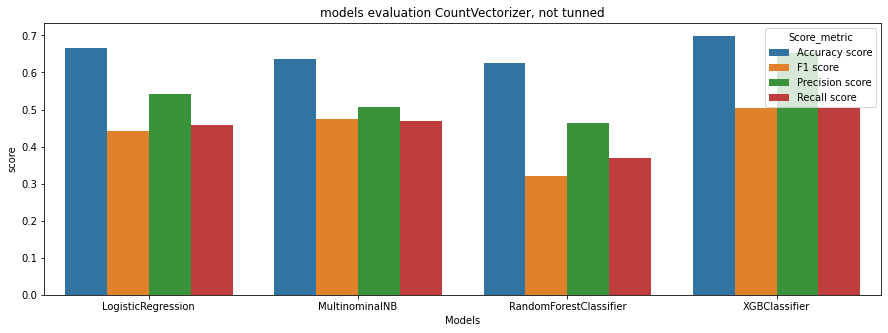

In [18]:
Scores_df_vec = pd.DataFrame(
    data=zip(accuracy, f1, precision, recall), 
    columns=[
        "Accuracy score",
        "F1 score",
        "Precision score",
        "Recall score",
        ]
    )
Scores_df_vec['Models'] = names
Scores_df_vec = Scores_df_vec.melt(
    id_vars=['Models'], 
    value_vars=[
        "Accuracy score",
        "F1 score", 
        "Precision score", 
        "Recall score",
        ], 
        var_name = "Score_metric", 
        value_name = "score",
        )
Scores_df_vec['data'] = "CountVectorizer"
plt.figure(figsize=(15,5))
plt.title("models evaluation CountVectorizer, not tunned")
sns.barplot(
    data=Scores_df_vec,
    x='Models',
    y='score',
    hue='Score_metric',
    )
plt.show()

In [20]:
names = [
    'LogisticRegression',
    "MultinominalNB",
    "RandomForestClassifier",
    "XGBClassifier",
    ]
models = [
    LogisticRegression(solver = "liblinear"), 
    MultinomialNB(),
    RandomForestClassifier(n_estimators=100, max_depth=10),  
    XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')]
train_data = tfidf
test_data = tfidfvectorizer.transform(X_test["review"])
f1 = []
accuracy = []
precision = []
recall = []


for model_name, model in zip(names, models):
    model.fit(train_data, _y_train)
    y_pred = model.predict(test_data)

    _f1_score = f1_score(_y_test,y_pred, average = "macro")
    f1.append(_f1_score)
    print(f"F1 {model_name}: {_f1_score}")

    _accuracy_score = accuracy_score(_y_test,y_pred)
    accuracy.append(_accuracy_score)
    print(f"accuracy {model_name}: {_accuracy_score}")

    _precision_score = precision_score(_y_test,y_pred, average = "macro",zero_division=0)
    precision.append(_precision_score)
    print(f"Precision {model_name}: {_precision_score}")
    
    _recall_score = recall_score(_y_test,y_pred, average = "macro")
    recall.append(_recall_score)
    print(f"recall {model_name}: {_recall_score}")

F1 LogisticRegression: 0.44633892624001814
accuracy LogisticRegression: 0.670405088717777
Precision LogisticRegression: 0.5527027069797904
recall LogisticRegression: 0.46817612968674066
F1 MultinominalNB: 0.31708538326679486
accuracy MultinominalNB: 0.6239445002417885
Precision MultinominalNB: 0.4500242012991202
recall MultinominalNB: 0.3666766134285527
F1 RandomForestClassifier: 0.31934696356017733
accuracy RandomForestClassifier: 0.6265855745266525
Precision RandomForestClassifier: 0.4769267578586951
recall RandomForestClassifier: 0.36852842111481826
F1 XGBClassifier: 0.5006097979238353
accuracy XGBClassifier: 0.7016702004984563
Precision XGBClassifier: 0.6521312735643795
recall XGBClassifier: 0.5042720062567421


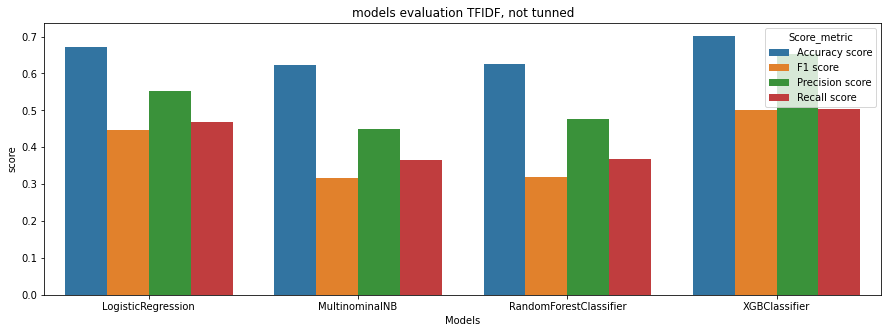

In [21]:
Scores_df_tfidf = pd.DataFrame(
    data=zip(accuracy, f1, precision, recall), 
    columns=[
        "Accuracy score",
        "F1 score",
        "Precision score",
        "Recall score",
        ]
    )
Scores_df_tfidf['Models'] = names
Scores_df_tfidf = Scores_df_tfidf.melt(
    id_vars=['Models'], 
    value_vars=[
        "Accuracy score",
        "F1 score", 
        "Precision score", 
        "Recall score",
        ], 
        var_name="Score_metric", 
        value_name="score",
        )
Scores_df_tfidf['data'] = "TFIDF"
plt.figure(figsize=(15,5))
plt.title("models evaluation TFIDF, not tunned")
sns.barplot(
    data=Scores_df_tfidf,
    x='Models',
    y='score',
    hue='Score_metric',
    )
plt.show()

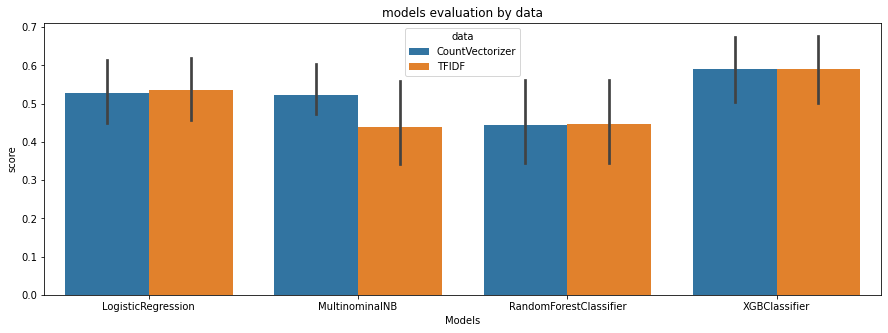

In [27]:
full_results = Scores_df_vec.append(Scores_df_tfidf)
plt.figure(figsize=(15,5))
plt.title("models evaluation by data")
sns.barplot(data=full_results, x='Models',y='score', hue='data')
plt.show()

## Make Pipeline

In [12]:
from sklearn.model_selection import GridSearchCV
# xgb_for_tunning
xgb_tuning = XGBClassifier(use_label_encoder=False, eval_metric = 'mlogloss')
params = {
        'gamma': [0.5, 1.5, 5],
        }

CV_xgb = GridSearchCV(
        estimator=xgb_tuning,
        param_grid=params,
        cv=3,
        verbose=2,
        n_jobs=4,
        )
CV_xgb.fit(tfidf, _y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of   9 | elapsed: 22.4min remaining:  6.4min
[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 25.4min finished


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='mlogloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample

In [13]:
CV_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [16]:
test_data = tfidfvectorizer.transform(X_test["review"])
f1 = []
accuracy = []
precision = []
recall = []



y_pred = CV_xgb.predict(test_data)
_f1_score = f1_score(_y_test,y_pred, average = "macro")
f1.append(_f1_score)
print(f"F1 : {_f1_score}")

_accuracy_score = accuracy_score(_y_test,y_pred)
accuracy.append(_accuracy_score)
print(f"accuracy : {_accuracy_score}")

_precision_score = precision_score(_y_test,y_pred, average = "macro",zero_division=0)
precision.append(_precision_score)
print(f"Precision : {_precision_score}")

_recall_score = recall_score(_y_test,y_pred, average = "macro")
recall.append(_recall_score)
print(f"recall : {_recall_score}")

F1 : 0.5007382904356956
accuracy : 0.7017073987278205
Precision : 0.6580659571088762
recall : 0.5044017590427009


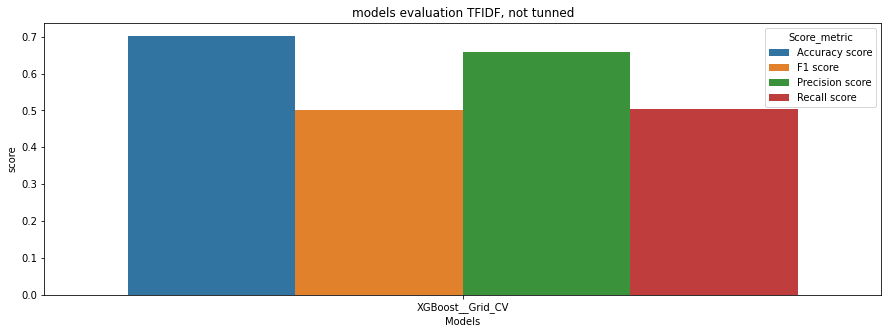

In [19]:
Scores_df_cv = pd.DataFrame(
    data=zip(
        accuracy,
        f1,
        precision,
        recall,
        ), 
    columns=[
        "Accuracy score",
        "F1 score",
        "Precision score",
        "Recall score",
        ]
    )
Scores_df_cv['Models'] = "XGBoost__Grid_CV"
Scores_df_cv = Scores_df_cv.melt(
    id_vars=['Models'], 
    value_vars=[
        "Accuracy score",
        "F1 score", 
        "Precision score", 
        "Recall score",
        ], 
        var_name="Score_metric", 
        value_name="score",
        )
plt.figure(figsize=(15,5))
plt.title("models evaluation TFIDF, not tunned")
sns.barplot(
    data=Scores_df_cv,
    x='Models',
    y='score',
    hue='Score_metric',
    )
plt.show()

In [14]:
filename = 'models/XGBClassifier_model_for_sentimental_analysis.sav'
joblib.dump(CV_xgb, filename)

['models/XGBClassifier_model_for_sentimental_analysis.sav']

In [23]:
#custom transformer
class Tfifd_dense_matrix_transformer(BaseEstimator, TransformerMixin):
    def __init__(self, tfidfvectorizer=None):
        pass

    def fit(self, X, y=None):
        tfidf = TfidfVectorizer(max_df=0.90, min_df=2, max_features=200, stop_words='english')
        self.tfidf = tfidf
        self.tfidf.fit(X)
        return self
    
    def transform(self, X,y=None):
        X_=X.copy()
        X_ = self.tfidf.transform(X_)
        return X_

steps = [
    ("Tfidf_dense_transformer", Tfifd_dense_matrix_transformer(tfidfvectorizer)),
]

sentiment_pipeline = Pipeline(steps = steps)